In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse
from alive_progress import alive_bar
import time
import os

# Load the data
train_data = pd.read_parquet("data/train_data.parquet")
test_data = pd.read_parquet("data/test_data.parquet")
# test_data = pd.read_csv("matching/matched/output_callput_full.csv")

# Convert expiry to datetime if it's not already
if train_data["expiry"].dtype != "datetime64[ns]":
    train_data["expiry"] = pd.to_datetime(train_data["expiry"])

# Get the target expiry date
target_date = pd.Timestamp("2025-05-08").date()

data_path = "data"
output_path = "output/"
temp_path = "tmp/"

sample_submission = pd.read_csv(f"{data_path}/sample_submission.csv")
submission_cols = sample_submission.columns.tolist()

In [130]:
# Find columns in test_data that have no NaN values
no_nan_cols = test_data.columns[~test_data.isna().any()].tolist()
print(f"Columns with no NaN values: {len(no_nan_cols)}")
print(no_nan_cols)

Columns with no NaN values: 44
['timestamp', 'underlying', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41']


In [88]:
test_data.columns

Index(['timestamp', 'underlying', 'call_iv_24000', 'call_iv_24100',
       'call_iv_24200', 'call_iv_24300', 'call_iv_24400', 'call_iv_24500',
       'call_iv_24600', 'call_iv_24700', 'call_iv_24800', 'call_iv_24900',
       'call_iv_25000', 'call_iv_25100', 'call_iv_25200', 'call_iv_25300',
       'call_iv_25400', 'call_iv_25500', 'call_iv_25600', 'call_iv_25700',
       'call_iv_25800', 'call_iv_25900', 'call_iv_26000', 'call_iv_26100',
       'call_iv_26200', 'call_iv_26300', 'call_iv_26400', 'call_iv_26500',
       'put_iv_23000', 'put_iv_23100', 'put_iv_23200', 'put_iv_23300',
       'put_iv_23400', 'put_iv_23500', 'put_iv_23600', 'put_iv_23700',
       'put_iv_23800', 'put_iv_23900', 'put_iv_24000', 'put_iv_24100',
       'put_iv_24200', 'put_iv_24300', 'put_iv_24400', 'put_iv_24500',
       'put_iv_24600', 'put_iv_24700', 'put_iv_24800', 'put_iv_24900',
       'put_iv_25000', 'put_iv_25100', 'put_iv_25200', 'put_iv_25300',
       'put_iv_25400', 'put_iv_25500', 'X0', 'X1', 'X2',

In [89]:
# Filter rows with the specified expiry date
expiry_filter = train_data["expiry"].dt.date == target_date
target_rows = train_data[expiry_filter]

# Get indices of rows to be used for validation (50% of the rows with target expiry)
validation_indices = target_rows.sample(frac=0.3, random_state=43).index

# Create validation set
val_data = train_data.loc[validation_indices].copy()

# Remove validation data from training set
train_data = train_data.drop(validation_indices)

# Print shapes to confirm
print(f"Original training data shape: {len(train_data) + len(val_data)}")
print(f"New training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Original training data shape: 178340
New training data shape: (154587, 97)
Validation data shape: (23753, 97)
Test data shape: (12065, 96)


In [90]:
pred_cols = list(
    filter(
        lambda x: x.startswith("call") or x.startswith("put"), val_data.columns.tolist()
    )
)
len(pred_cols)

52

In [91]:
import os
import random

# Check if files already exist
sample_val_path = "final_day/sample_val.parquet"
val_Y_path = "final_day/val_Y.parquet"

if os.path.exists(sample_val_path) and os.path.exists(val_Y_path):
    # Load existing files
    sample_val = pd.read_parquet(sample_val_path)
    val_Y = pd.read_parquet(val_Y_path)
    print("Loaded existing files")
    print(f"sample_val shape: {sample_val.shape}")
    print(f"val_Y shape: {val_Y.shape}")
else:
    # Create val_Y from pred_cols in val_data
    val_Y = val_data.copy()

    # Initialize sample_val as a copy of val_Y
    sample_val = val_Y.copy()

    # Split pred_cols into call and put columns
    call_cols = [col for col in pred_cols if col.startswith("call")]
    put_cols = [col for col in pred_cols if col.startswith("put")]

    # Set random seed for reproducibility
    np.random.seed(43)

    # For each row, randomly set columns to NaN
    for idx in sample_val.index:
        # Choose number of columns to set to NaN (normal distribution between 4-24)
        num_call_cols_to_nan = int(np.clip(np.random.normal(14, 4), 4, 24))
        num_put_cols_to_nan = int(np.clip(np.random.normal(14, 4), 4, 24))

        # Randomly choose columns from both call and put
        call_cols_to_nan = np.random.choice(
            call_cols, size=num_call_cols_to_nan, replace=False
        )
        put_cols_to_nan = np.random.choice(
            put_cols, size=num_put_cols_to_nan, replace=False
        )

        # Set chosen columns to NaN for this row
        sample_val.loc[idx, call_cols_to_nan] = np.nan
        sample_val.loc[idx, put_cols_to_nan] = np.nan

    # Create directories if they don't exist
    os.makedirs("final_day", exist_ok=True)

    # Save the dataframes
    sample_val.to_parquet(sample_val_path)
    val_Y.to_parquet(val_Y_path)

    print("Created and saved new files")
    print(f"sample_val shape: {sample_val.shape}")
    print(f"val_Y shape: {val_Y.shape}")
    print(f"Average NaN columns per row: {sample_val.isna().sum(axis=1).mean():.2f}")

Loaded existing files
sample_val shape: (23753, 97)
val_Y shape: (23753, 97)


In [92]:
sample_val.isna().sum().sum()

640329

Min NaNs: 8
Max NaNs: 47
Mean NaNs: 26.96
Median NaNs: 27.0
Percentage of rows with no NaNs: 0.00%


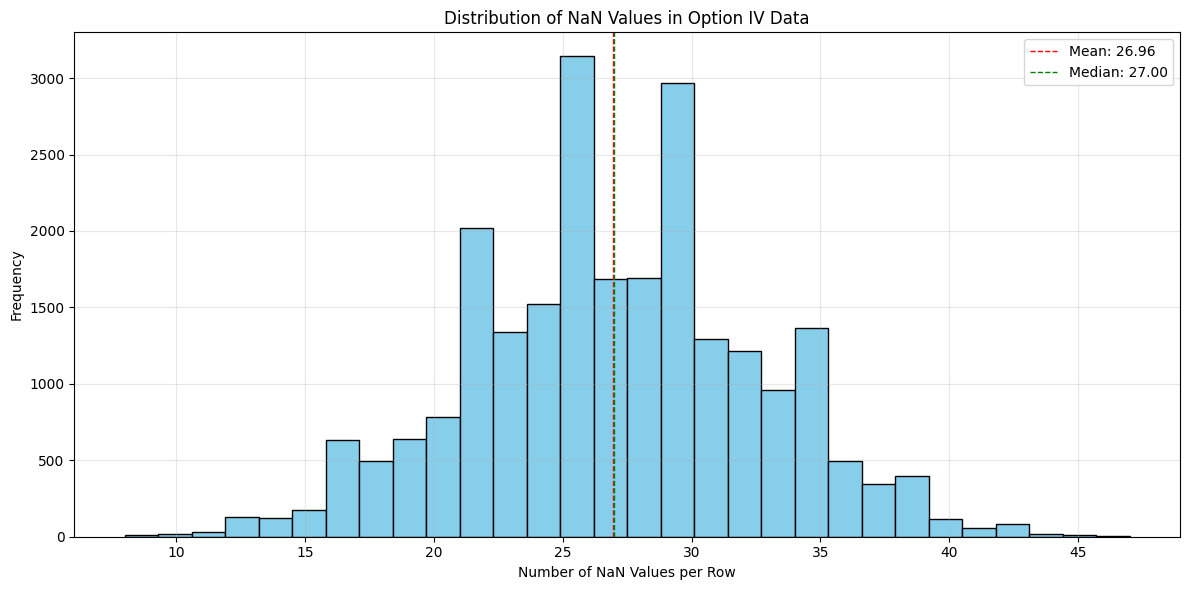

In [93]:
# Create a heatmap of NaN values over time
# First, creasample_valries that counts the number of NaNs in each row
nan_counts = sample_val[pred_cols].isna().sum(axis=1)

# Plot the distribution of NaN counts
plt.figure(figsize=(12, 6))
plt.hist(nan_counts, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of NaN Values in Option IV Data")
plt.xlabel("Number of NaN Values per Row")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)

# Add some statistics
plt.axvline(
    nan_counts.mean(),
    color="red",
    linestyle="dashed",
    linewidth=1,
    label=f"Mean: {nan_counts.mean():.2f}",
)
plt.axvline(
    nan_counts.median(),
    color="green",
    linestyle="dashed",
    linewidth=1,
    label=f"Median: {nan_counts.median():.2f}",
)

# Print summary statistics
print(f"Min NaNs: {nan_counts.min()}")
print(f"Max NaNs: {nan_counts.max()}")
print(f"Mean NaNs: {nan_counts.mean():.2f}")
print(f"Median NaNs: {nan_counts.median()}")
print(f"Percentage of rows with no NaNs: {100 * (nan_counts == 0).mean():.2f}%")

plt.legend()
plt.tight_layout()
plt.show()

In [94]:
sample_val[pred_cols].to_csv("final_day/sample_val_matching.csv", index=False, header=False)

--------------------------------------------------------------------------------------------

In [95]:
partial_df = pd.read_csv("final_day/matching/ouptut.csv", header=None)
partial_df.columns = pred_cols
print(partial_df.isna().sum().sum())
sample_val_full = sample_val.copy()
print(sample_val_full.isna().sum().sum())
print(sample_val_full[pred_cols].shape, partial_df.shape)
sample_val_full[pred_cols] = partial_df.values
print(sample_val_full.isna().sum().sum())
sample_val_full.to_csv("final_day/output/matching.csv", index=False)

95
640329
(23753, 52) (23753, 52)
95


In [96]:
sample_val_full[pred_cols]

,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,...,put_iv_24100,put_iv_24200,put_iv_24300,put_iv_24400,put_iv_24500,put_iv_24600,put_iv_24700,put_iv_24800,put_iv_24900,put_iv_25000
158881,0.435793,0.409610,0.383775,0.356050,0.324041,0.290866,0.256701,0.224547,0.193787,0.171784,...,0.257653,0.224571,0.194825,0.170470,0.159481,0.161576,0.166743,0.179010,0.190790,0.199894
117518,0.206224,0.196965,0.187751,0.178467,0.170073,0.161772,0.154975,0.148754,0.143494,0.139779,...,0.155349,0.148950,0.143385,0.139684,0.137425,0.136817,0.137517,0.139019,0.143233,0.144093
155403,0.287715,0.270770,0.247234,0.223072,0.199603,0.173109,0.149605,0.127296,0.105347,0.092642,...,0.150855,0.126000,0.105350,0.092436,0.094310,0.108763,0.125630,0.140168,0.156281,0.172335
159498,0.426385,0.396069,0.373041,0.341066,0.310434,0.276962,0.242813,0.210069,0.181669,0.159274,...,0.244192,0.209144,0.180477,0.157767,0.153256,0.158080,0.171870,0.184260,0.196214,0.206709
106693,0.211267,0.205243,0.196625,0.189550,0.182064,0.174267,0.167218,0.160473,0.154357,0.149974,...,0.167240,0.160747,0.154536,0.149348,0.145434,0.142784,0.140871,0.140249,0.140879,0.141326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159879,0.407320,0.377406,0.349971,0.319716,0.288763,0.256396,0.223363,0.190363,0.161707,0.143182,...,0.223544,0.189848,0.161163,0.143433,0.142739,0.155520,0.170590,0.183220,0.201190,0.217458
152103,0.281599,0.263384,0.241601,0.218548,0.194417,0.171316,0.149054,0.126040,0.105868,0.093440,...,0.149312,0.125824,0.105625,0.093685,0.095311,0.108715,0.125723,0.141319,0.156084,0.173793
145579,0.277396,0.256449,0.236870,0.214142,0.191823,0.168970,0.146202,0.125063,0.105540,0.093903,...,0.146666,0.123999,0.104915,0.093799,0.094252,0.104744,0.121751,0.138903,0.155443,0.169816
171749,0.386717,0.355572,0.323200,0.296829,0.260966,0.227280,0.190997,0.155679,0.125819,0.115561,...,0.190687,0.155132,0.125089,0.115049,0.126005,0.147515,0.164791,0.184988,0.198899,0.228256


In [97]:
sample_val_full

,timestamp,underlying,expiry,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
158881,1746590742000000000,24433.0,2025-05-08,0.435793,0.409610,0.383775,0.356050,0.324041,0.290866,0.256701,...,-0.022656,0.006262,2.553592e+06,-0.001931,2.372125,0.068108,-1.522534e+06,-3.048516e+06,1.254699e+06,-0.000000e+00
117518,1746176782000000000,24285.5,2025-05-08,0.206224,0.196965,0.187751,0.178467,0.170073,0.161772,0.154975,...,0.003836,-0.004734,6.693594e+05,0.010055,1.315715,0.030237,5.235704e+04,-8.124241e+06,1.313372e+06,-1.000000e-06
155403,1746520665000000000,24387.5,2025-05-08,0.287715,0.270770,0.247234,0.223072,0.199603,0.173109,0.149605,...,0.001037,0.003309,2.847738e+06,0.008796,0.648142,0.041674,3.459928e+05,-2.764208e+07,2.203250e+06,0.000000e+00
159498,1746591359000000000,24384.6,2025-05-08,0.426385,0.396069,0.373041,0.341066,0.310434,0.276962,0.242813,...,0.035097,-0.030470,-3.629051e+06,0.146150,-8.941554,1.278703,6.211531e+06,7.623811e+06,-5.587995e+05,3.208558e+06
106693,1746165957000000000,24329.3,2025-05-08,0.211267,0.205243,0.196625,0.189550,0.182064,0.174267,0.167218,...,0.001900,0.002318,-1.051215e+06,0.026776,0.242156,0.025405,2.716713e+06,-3.698245e+06,-0.000000e+00,-0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159879,1746591740000000000,24335.0,2025-05-08,0.407320,0.377406,0.349971,0.319716,0.288763,0.256396,0.223363,...,0.008603,-0.004291,-1.986960e+06,0.012081,-1.567061,0.025376,-1.849046e+05,9.476678e+05,-8.574375e+05,-0.000000e+00
152103,1746517365000000000,24379.3,2025-05-08,0.281599,0.263384,0.241601,0.218548,0.194417,0.171316,0.149054,...,-0.009330,0.001730,3.085312e+05,-0.010100,0.017339,0.041731,-5.464379e+06,9.938785e+06,0.000000e+00,0.000000e+00
145579,1746510841000000000,24383.8,2025-05-08,0.277396,0.256449,0.236870,0.214142,0.191823,0.168970,0.146202,...,-0.006017,-0.014316,-5.171651e+05,0.009618,-0.905712,-0.035879,-5.117804e+05,-3.953448e+07,1.914297e+05,-0.000000e+00
171749,1746603610000000000,24348.2,2025-05-08,0.386717,0.355572,0.323200,0.296829,0.260966,0.227280,0.190997,...,0.001378,0.003366,1.357577e+06,0.016415,0.766966,-0.016124,-9.293144e+05,6.414991e+06,3.323359e+04,0.000000e+00


In [114]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.manifold import TSNE
from sklearn.preprocessing import minmax_scale


def reconstruct_time_id_order(df_prices):
    df_prices = df_prices.pivot(index="timestamp", columns="stock_id", values="underlying")

    # t-SNE to recovering time-id order
    clf = TSNE(n_components=1, perplexity=400, random_state=0, n_iter=2000)
    compressed = clf.fit_transform(
        pd.DataFrame(minmax_scale(df_prices.fillna(df_prices.mean())))
    )

    order = np.argsort(compressed[:, 0])
    ordered = df_prices.reindex(order).reset_index(drop=True)


    return ordered

In [115]:
df_prices = sample_val_full[["timestamp", "underlying"]].copy()
df_prices.reset_index(drop=True, inplace=True)
sample_val_full.timestamp = df_prices.index.values
df_prices["stock_id"] = 1
print(df_prices.head())
ordered_prices = reconstruct_time_id_order(df_prices)
ordered_prices

   timestamp  underlying  stock_id
0          0     24433.0         1
1          1     24285.5         1
2          2     24387.5         1
3          3     24384.6         1
4          4     24329.3         1


stock_id,1
0,24229.4
1,24230.7
2,24231.0
3,24231.4
4,24233.8
...,...
23748,24656.1
23749,24656.1
23750,24656.1
23751,24664.5


In [119]:
ordered_prices.index

RangeIndex(start=0, stop=23753, step=1)

In [105]:
sample_val

,timestamp,underlying,expiry,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
158881,1746590742000000000,24433.0,2025-05-08,0.435793,0.409610,0.383775,0.356050,NaN,NaN,NaN,...,-0.022656,0.006262,2.553592e+06,-0.001931,2.372125,0.068108,-1.522534e+06,-3.048516e+06,1.254699e+06,-0.000000e+00
117518,1746176782000000000,24285.5,2025-05-08,NaN,NaN,0.187751,0.178467,0.170073,0.161772,0.154975,...,0.003836,-0.004734,6.693594e+05,0.010055,1.315715,0.030237,5.235704e+04,-8.124241e+06,1.313372e+06,-1.000000e-06
155403,1746520665000000000,24387.5,2025-05-08,NaN,0.270770,NaN,NaN,NaN,0.173109,NaN,...,0.001037,0.003309,2.847738e+06,0.008796,0.648142,0.041674,3.459928e+05,-2.764208e+07,2.203250e+06,0.000000e+00
159498,1746591359000000000,24384.6,2025-05-08,0.426385,0.396069,NaN,0.341066,NaN,NaN,0.242813,...,0.035097,-0.030470,-3.629051e+06,0.146150,-8.941554,1.278703,6.211531e+06,7.623811e+06,-5.587995e+05,3.208558e+06
106693,1746165957000000000,24329.3,2025-05-08,NaN,NaN,0.196625,NaN,NaN,NaN,NaN,...,0.001900,0.002318,-1.051215e+06,0.026776,0.242156,0.025405,2.716713e+06,-3.698245e+06,-0.000000e+00,-0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159879,1746591740000000000,24335.0,2025-05-08,NaN,0.377406,0.349971,NaN,NaN,0.256396,NaN,...,0.008603,-0.004291,-1.986960e+06,0.012081,-1.567061,0.025376,-1.849046e+05,9.476678e+05,-8.574375e+05,-0.000000e+00
152103,1746517365000000000,24379.3,2025-05-08,0.281599,0.263384,0.241601,NaN,NaN,NaN,0.149054,...,-0.009330,0.001730,3.085312e+05,-0.010100,0.017339,0.041731,-5.464379e+06,9.938785e+06,0.000000e+00,0.000000e+00
145579,1746510841000000000,24383.8,2025-05-08,0.277396,0.256449,NaN,0.214142,0.191823,0.168970,0.146202,...,-0.006017,-0.014316,-5.171651e+05,0.009618,-0.905712,-0.035879,-5.117804e+05,-3.953448e+07,1.914297e+05,-0.000000e+00
171749,1746603610000000000,24348.2,2025-05-08,0.386717,0.355572,0.323200,0.296829,NaN,NaN,0.190997,...,0.001378,0.003366,1.357577e+06,0.016415,0.766966,-0.016124,-9.293144e+05,6.414991e+06,3.323359e+04,0.000000e+00


In [125]:
# Create a copy of sample_val_full with a 'done' column
df_copy = sample_val_full.copy()
df_copy['done'] = False

# Initialize df_sorted as an empty dataframe with the same structure
df_sorted = pd.DataFrame(columns=df_copy.columns)

# For each index in ordered_prices
for i in ordered_prices.index:
  underlying_value = ordered_prices.loc[i, 1]  # Get underlying value from column 1
  
  # Find a row in df_copy where done=False and underlying matches
  available_rows = df_copy[(df_copy['done'] == False) & (df_copy['underlying'] == underlying_value)]
  
  if len(available_rows) > 0:
    # Select the first available row
    selected_row = available_rows.iloc[0].copy()
    selected_idx = available_rows.index[0]
    
    # Add to df_sorted
    df_sorted = pd.concat([df_sorted, selected_row.to_frame().T], ignore_index=True)
    
    # Mark as done
    df_copy.loc[selected_idx, 'done'] = True

# Remove the 'done' column from df_sorted
df_sorted = df_sorted.drop('done', axis=1)

print(f"df_sorted shape: {df_sorted.shape}")
print(f"Rows processed: {len(ordered_prices)}")

df_sorted shape: (23753, 97)
Rows processed: 23753


In [127]:
df_sorted

,timestamp,underlying,expiry,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,4448,24229.4,2025-05-08 00:00:00,0.211109,0.202257,0.195156,0.18697,0.179835,0.172091,0.165898,...,-0.044937,-0.002464,-1113893.75,-0.088392,-6.949501,0.217803,4531592.614273,-18632427.796379,-184615.625,0.0
1,9963,24230.7,2025-05-08 00:00:00,0.213741,0.205147,0.197214,0.188231,0.180478,0.172328,0.165785,...,-0.015578,0.005642,-0.0,-0.053075,-7.281855,-0.190637,-3273225.538111,4845191.986789,0.0,-0.0
2,18893,24231.0,2025-05-08 00:00:00,0.212515,0.202695,0.194525,0.187041,0.180018,0.172328,0.165622,...,-0.007162,0.020737,-4234505.096726,-0.075747,-7.835876,-0.107508,-86928766.251719,-123088093.30357,0.0,-793468.75
3,20426,24231.4,2025-05-08 00:00:00,0.213741,0.205147,0.197214,0.188231,0.180478,0.172328,0.165785,...,-0.005375,-0.016877,-0.0,-0.023142,-6.805482,0.370221,5335119.370262,-13097986.49159,0.0,0.0
4,5208,24233.8,2025-05-08 00:00:00,0.212581,0.203754,0.195216,0.18789,0.179728,0.172328,0.16584,...,0.016466,0.004014,207392.578125,0.009613,-6.153555,-0.286409,985934.644054,27823494.432044,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23748,18549,24656.1,2025-05-08 00:00:00,0.237247,0.228901,0.219304,0.21132,0.203571,0.193843,0.185564,...,-0.003629,-0.011539,-1074049.330357,0.085,-0.21195,-0.002783,-111944.795299,-8344703.698532,-629600.0,-0.0
23749,23198,24656.1,2025-05-08 00:00:00,0.238584,0.229767,0.220263,0.211777,0.203114,0.193995,0.186492,...,-0.007268,-0.002938,2326693.576389,-0.012632,1.139351,0.042156,-36913.736214,-597440.600193,0.0,-0.0
23750,23675,24656.1,2025-05-08 00:00:00,0.238033,0.229563,0.220425,0.211532,0.203114,0.193995,0.186283,...,-0.011172,0.012429,-773389.880952,0.014571,-0.185259,-0.023196,340497.495957,-955227.864578,0.0,-0.0
23751,20736,24664.5,2025-05-08 00:00:00,0.239005,0.230447,0.222922,0.213027,0.203325,0.19399,0.186283,...,0.010824,-0.013502,-4902901.190476,0.014197,-1.811847,-0.029922,839428.816094,199377.976206,-1185344.308036,-0.000002


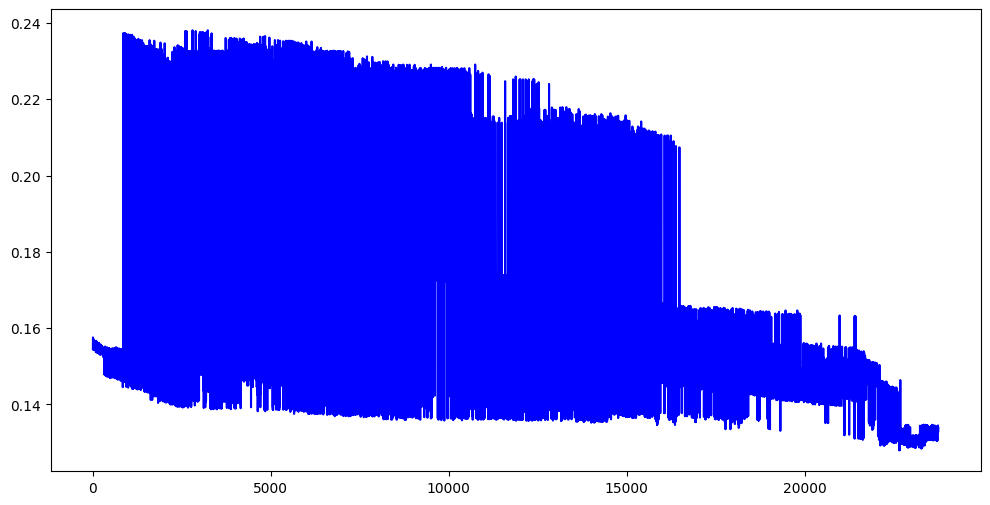

In [128]:
plt.figure(figsize=(12, 6))
plt.plot(df_sorted.index, df_sorted.call_iv_25000,color="blue", label="Call 4000")

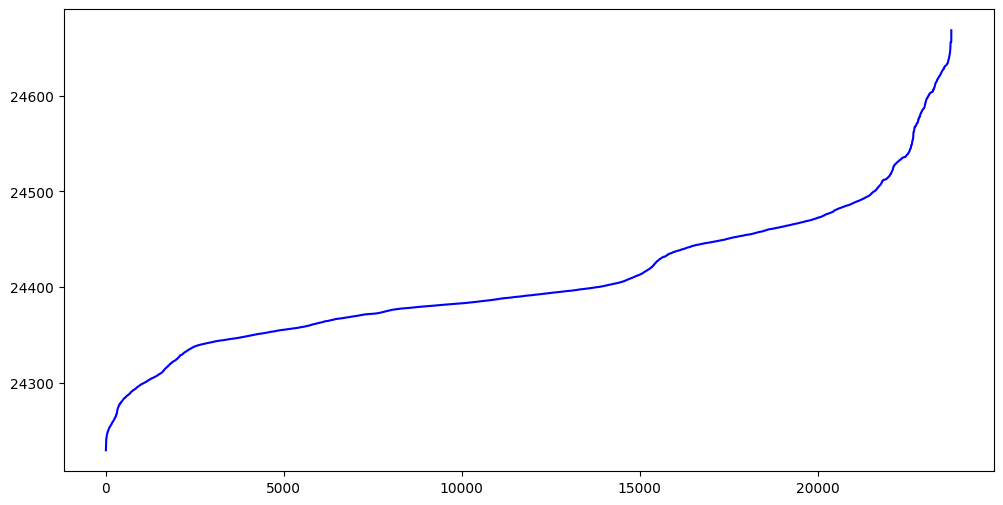

In [117]:
plt.figure(figsize=(12, 6))
plt.plot(df_sorted.index, ordered_prices[1], label="Underlying Price", color="blue")

In [103]:
# Convert underlying column to categorical with the desired order
sample_val_full["underlying"] = pd.Categorical(
    sample_val_full["underlying"],
    categories=ordered_prices["underlying"].tolist(),
    ordered=True,
)

# Sort by the categorical column
sorted_sample_val_full = sample_val_full.sort_values("underlying")

# Optional: convert back to regular string if needed
sorted_sample_val_full["underlying"] = sorted_sample_val_full["underlying"].astype(str)

KeyError: 'underlying'